In [1]:
import pandas as pd
import scipy
import numpy as np

from constants import HARD_WIRED_GENOME_A_MATRIX_PATH, STRING_EXTRACTED_URL_PATH
from mapping import get_unique_genes, generate_unique_gene_set_Huri

In [5]:
# Counting number of unique proteins from STRING

with open(STRING_EXTRACTED_URL_PATH, "r") as stringfile:
    lines = stringfile.readlines()
    proteinset = set()
    for line in lines:
        p1, p2, score = line.strip().split()
        proteinset.add(p1)
        proteinset.add(p1)
    print(f"Number of Unique Proteins in STRING: {len(proteinset)}")
    

Number of Unique Proteins in STRING: 19623


In [4]:
# Counting unique Genes

genelist = get_unique_genes()

huri_genes = generate_unique_gene_set_Huri()

Unique genes from STRING: 19699
Unique genes from HURI: 11603
Total unique genes: 24057
Unique Genes from HI-Union: 9094
Unique Genes from LIT-BM: 6047
Total unique genes HURI ( union of HI-Union + LIT-BM ): 11603


In [4]:
A_matrix = pd.read_csv(HARD_WIRED_GENOME_A_MATRIX_PATH, index_col=0)

In [16]:
np_arr = A_matrix.to_numpy()

In [18]:
df = A_matrix.copy()

df = df.clip(lower=0, upper=np.iinfo(np.uint32).max).astype(np.uint32)

# df = df.astype(np.int64)
mat_dict = {
    'data': df.to_numpy(),
    'columns': df.columns.to_list()
}
scipy.io.savemat('/scratch/indikar_root/indikar1/shared_data/HWG/operations/A_matrix.mat', mat_dict)

In [20]:

mat = scipy.io.loadmat('/scratch/indikar_root/indikar1/shared_data/HWG/operations/A_matrix.mat')

In [5]:
mat = scipy.io.loadmat('/scratch/indikar_root/indikar1/shared_data/HWG/operations/DSET038-37_Combined_GRCh38p14_GRCh37p13_EnsemblBioMart_allGenes.mat')
gene_metadata = pd.read_csv('/scratch/indikar_root/indikar1/shared_data/HWG/operations/DSET038_37_Combined_GRCh38p14_GRCh37p13.txt')

gene_metadata

,GeneStableIDVersion,GeneStableID,GeneName,ReferenceGenome,GeneAliases,GeneAliasesWithSources,GeneDescription,GeneType,ChromosomescaffoldName,GeneStartbp,GeneEndbp,Strand,TranscriptCount,SourceOfGeneName,Sourcegene,GeneLengthStart2End,GeneLengthUnionOfExons,ExonCount
0,ENSG00000000003.16,ENSG00000000003,TSPAN6,GRCh38.p14,T245|TM4SF6|TSPAN-6|TSPAN6|TSPAN6|HGNC:11858|N...,T245[EnsemblGeneSynonym]|TM4SF6[EnsemblGeneSyn...,tetraspanin 6 [Source:HGNC Symbol;Acc:HGNC:11858],protein_coding,X,100627108,100639991,-1,4,HGNC Symbol,ensembl_havana,12884,4530,27
1,ENSG00000000005.6,ENSG00000000005,TNMD,GRCh38.p14,BRICD4|CHM1L|MYODULIN|TEM|TENDIN|TNMD|TNMD|HGN...,BRICD4[EnsemblGeneSynonym]|CHM1L[EnsemblGeneSy...,tenomodulin [Source:HGNC Symbol;Acc:HGNC:17757],protein_coding,X,100584936,100599885,1,2,HGNC Symbol,ensembl_havana,14950,1476,10
2,ENSG00000000419.14,ENSG00000000419,DPM1,GRCh38.p14,CDGIE|MPDS|DPM1|DPM1|HGNC:3005|NCBI:8813,CDGIE[EnsemblGeneSynonym]|MPDS[EnsemblGeneSyno...,dolichyl-phosphate mannosyltransferase subunit...,protein_coding,20,50934867,50959140,-1,16,HGNC Symbol,ensembl_havana,24274,9276,109
3,ENSG00000000457.14,ENSG00000000457,SCYL3,GRCh38.p14,PACE-1|PACE1|SCYL3|SCYL3|HGNC:19285|NCBI:57147,PACE-1[EnsemblGeneSynonym]|PACE1[EnsemblGeneSy...,SCY1 like pseudokinase 3 [Source:HGNC Symbol;A...,protein_coding,1,169849631,169894267,-1,5,HGNC Symbol,ensembl_havana,44637,6883,63
4,ENSG00000000460.17,ENSG00000000460,FIRRM,GRCh38.p14,APOLO1|C1ORF112|FLIP|FLJ10706|MEICA1|FIRRM|FIR...,APOLO1[EnsemblGeneSynonym]|C1ORF112[EnsemblGen...,FIGNL1 interacting regulator of recombination ...,protein_coding,1,169662007,169854080,1,9,HGNC Symbol,ensembl_havana,192074,5970,151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126823,ENSG00000273486.1,ENSG00000273486,RP11-731C17.2,GRCh37.p13,NaN,NaN,NaN,antisense,3,136556180,136557863,-1,1,Clone-based (Vega) gene,havana,1684,1684,1
126824,ENSG00000273488.1,ENSG00000273488,RP11-114I8.4,GRCh37.p13,NaN,NaN,NaN,lincRNA,3,100080031,100080481,1,1,Clone-based (Vega) gene,havana,451,451,1
126825,ENSG00000273490.1,ENSG00000273490,TSEN34,GRCh37.p13,LENG5|PCH2C|SEN34|SEN34L|TSEN34|TSEN34|HGNC:15...,LENG5[EnsemblGeneSynonym]|PCH2C[EnsemblGeneSyn...,TSEN34 tRNA splicing endonuclease subunit [Sou...,protein_coding,HSCHR19LRC_LRC_J_CTG1,54693789,54697585,1,7,HGNC Symbol,ensembl_havana,3797,2736,31
126826,ENSG00000273491.1,ENSG00000273491,RP11-138A9.2,GRCh37.p13,NaN,NaN,NaN,lincRNA,HG1308_PATCH,130600118,130603315,1,1,Clone-based (Vega) gene,havana,3198,3198,1


In [6]:
filtered_gene_metadata = gene_metadata[gene_metadata['GeneType'] == 'protein_coding']

chromosome_list = [str(i) for i in range(23)]
filtered_gene_metadata = filtered_gene_metadata[filtered_gene_metadata['ChromosomescaffoldName'].isin(chromosome_list)]

In [13]:
len(filtered_gene_metadata)

38072

In [2]:
from constants import HARD_WIRED_GENOME_A_MATRIX_PATH

A_matrix = pd.read_csv(HARD_WIRED_GENOME_A_MATRIX_PATH, index_col = 0)

In [3]:
headers = A_matrix.columns.tolist()

In [7]:
filtered_gene_metadata = filtered_gene_metadata[filtered_gene_metadata['GeneStableID'].isin(headers)]
len(filtered_gene_metadata)

36885

In [8]:
filtered_gene_metadata = filtered_gene_metadata[['GeneStableID', 'ChromosomescaffoldName']].drop_duplicates()


In [9]:
filtered_gene_metadata

,GeneStableID,ChromosomescaffoldName
2,ENSG00000000419,20
3,ENSG00000000457,1
4,ENSG00000000460,1
5,ENSG00000000938,1
6,ENSG00000000971,1
...,...,...
124453,ENSG00000268861,19
124566,ENSG00000269028,3
125279,ENSG00000270188,1
125366,ENSG00000270394,4


In [11]:
group_dict = filtered_gene_metadata.groupby('ChromosomescaffoldName')['GeneStableID'].apply(list).to_dict()

In [12]:
# sorted_groups = sorted([ int(i) for i in group_dict.keys()])

sorted_groups = dict(sorted(group_dict.items()))

In [50]:
ch19 = df_sorted.loc[sorted_groups['19'], sorted_groups['19']]

In [48]:
ch19 = df_sorted.loc[sorted_groups['21'], sorted_groups['21']]

In [13]:
flat_col_order = [col for group in sorted_groups.values() for col in group]

In [14]:
flat_col_order[:10]

['ENSG00000000457',
 'ENSG00000000460',
 'ENSG00000000938',
 'ENSG00000000971',
 'ENSG00000001460',
 'ENSG00000001461',
 'ENSG00000004455',
 'ENSG00000004487',
 'ENSG00000006555',
 'ENSG00000007341']

In [21]:
# df_sorted = A_matrix[flat_col_order, flat_col_order]

df_sorted = A_matrix.loc[flat_col_order, flat_col_order]

In [22]:
df_sorted

,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001460,ENSG00000001461,ENSG00000004455,ENSG00000004487,ENSG00000006555,ENSG00000007341,...,ENSG00000288841,ENSG00000289701,ENSG00000291303,ENSG00000130723,ENSG00000172014,ENSG00000183148,ENSG00000196312,ENSG00000204352,ENSG00000205549,ENSG00000241978
ENSG00000000457,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000000460,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000000938,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000000971,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000001460,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000183148,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
ENSG00000196312,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000204352,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000205549,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
import matplotlib.pyplot as plt

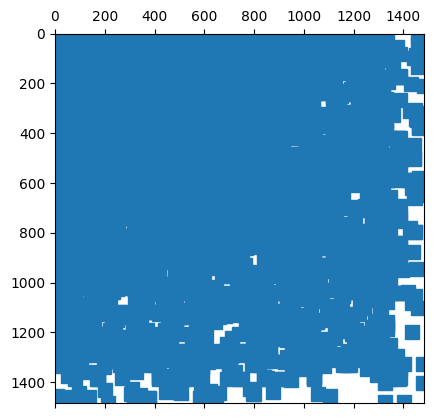

In [45]:
from scipy.sparse import csr_matrix

sparse_adj = csr_matrix(ch19.values)
plt.spy(sparse_adj)
plt.show()

# Block averaging to downsample matrix to something like 500x500
# def block_mean(arr, factor):
#     return arr.reshape(
#         arr.shape[0] // factor, factor,
#         arr.shape[1] // factor, factor
#     ).mean(axis=(1, 3))

# downsample_factor = 40  # 20000 / 500
# matrix = df.values
# small_matrix = block_mean(df_sorted, downsample_factor)


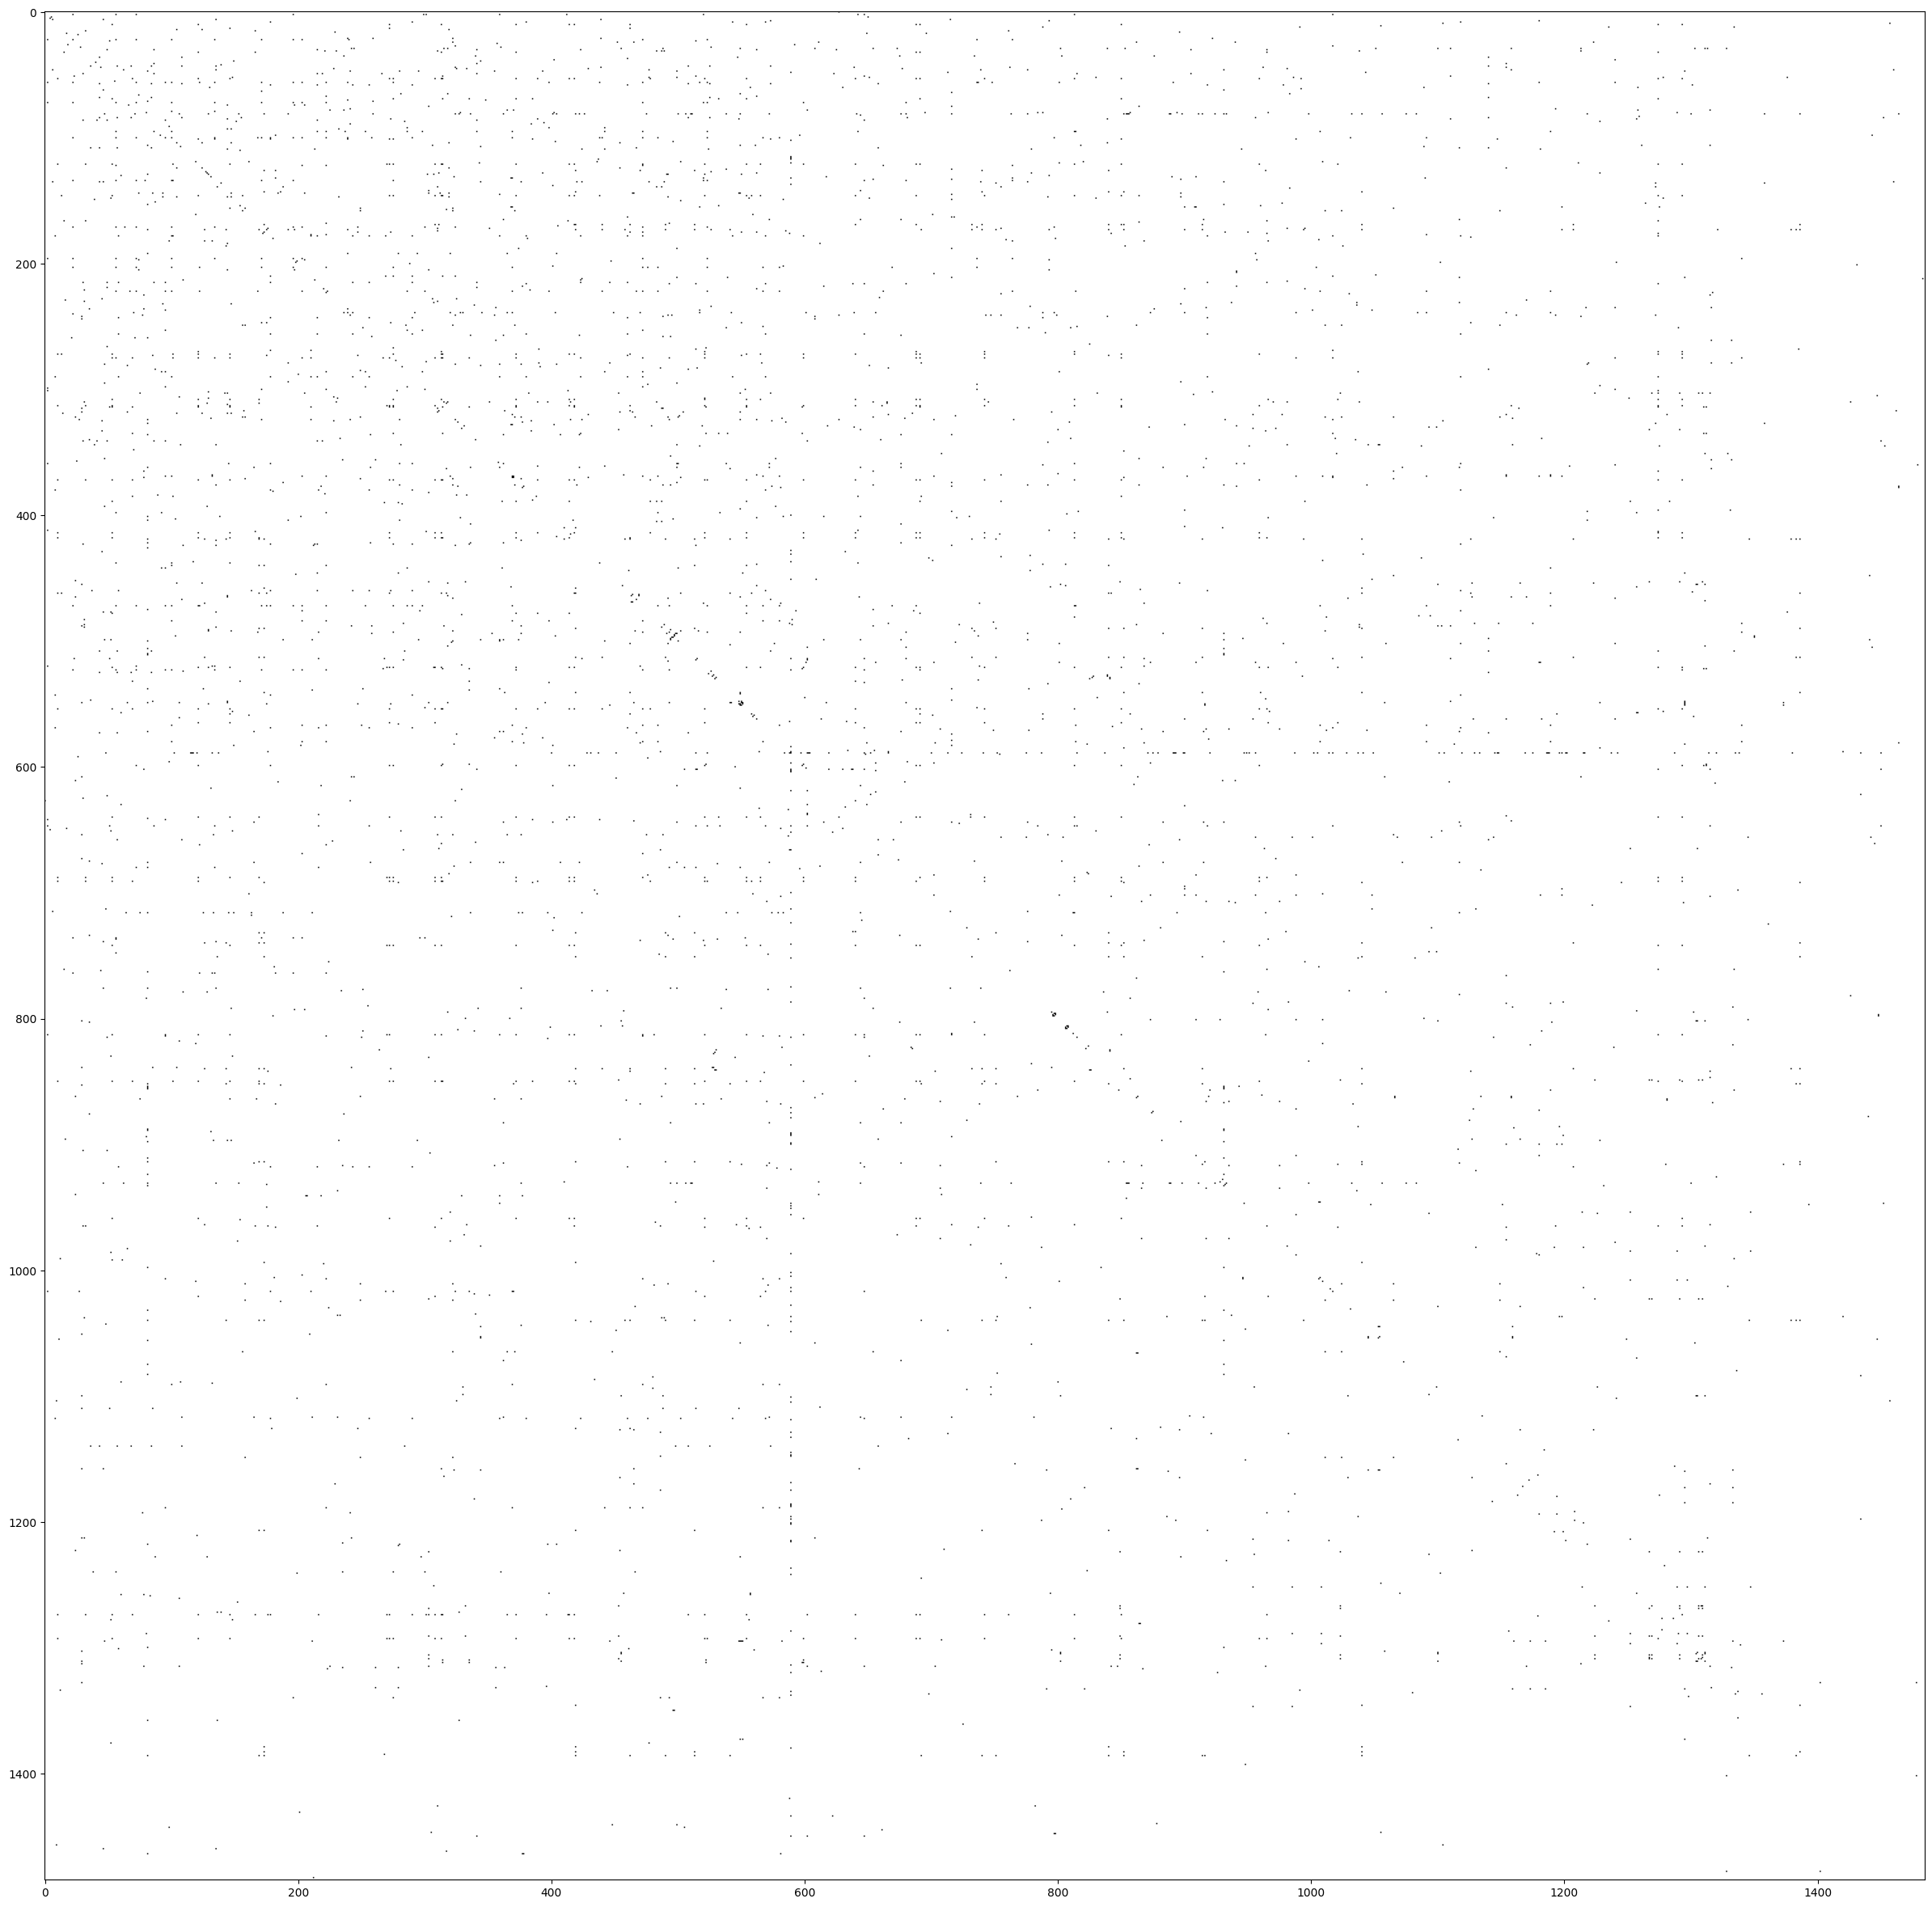

In [43]:
plt.figure(figsize=(30, 30))
plt.imshow(ch19.values, cmap='binary', aspect='auto')
# plt.colorbar(label='Value')
plt.show()

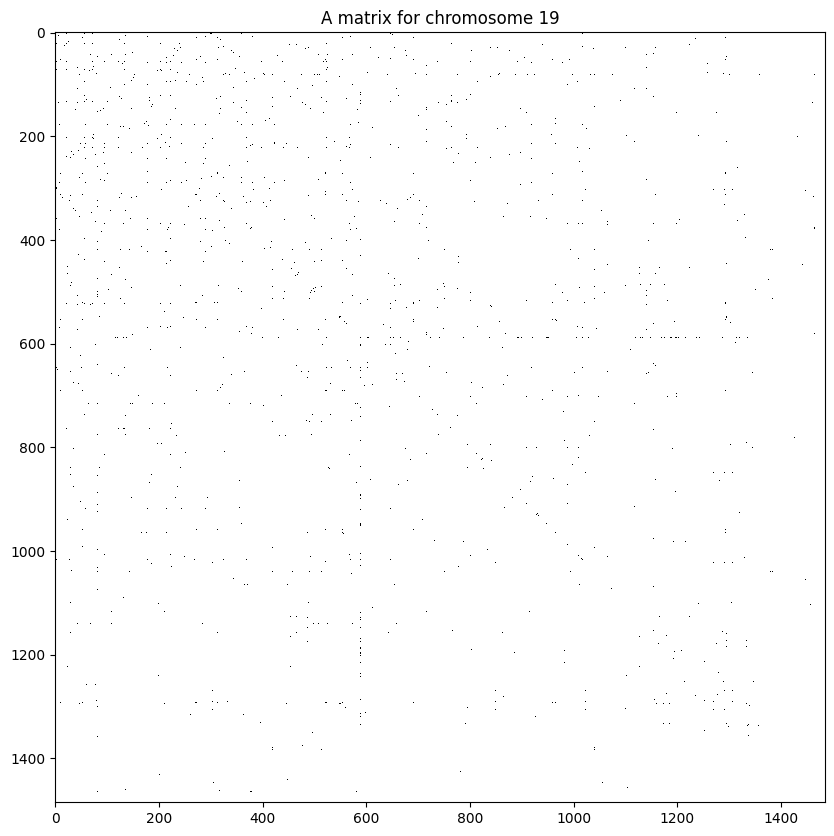

In [68]:
# masked = np.ma.masked_where(ch19 == 0, ch19)

plt.figure(figsize=(10, 10))

from matplotlib.colors import ListedColormap

ch19val = ch19.values[:300,:300]
cmap = ListedColormap(['black', 'blue'])
plt.imshow(ch19, cmap='binary', interpolation='nearest')
plt.title("A matrix for chromosome 19")
# plt.imshow(ch19.values, cmap='binary', aspect='auto')
# plt.colorbar(label='Value')
plt.savefig('chr19_A_matrix_sub.png',  bbox_inches='tight', pad_inches=0.1, dpi=300)

In [ ]:
plt.xticks(ticks=np.arange(len(flat_col_order)), labels=flat_col_order, rotation=90)
plt.yticks(ticks=np.arange(df_sorted.shape[0]))

col_index = 0
for group_cols in sorted_groups.values():
    col_index += len(group_cols)
    if col_index < len(flat_col_order):
        plt.axvline(x=col_index - 0.5, color='white', linestyle='--', linewidth=2)

plt.title("Matrix with Group Boundaries")
plt.tight_layout()
plt.show()

In [36]:
# Block averaging to downsample matrix to something like 500x500
def block_mean(arr, factor):
    return arr.reshape(
        arr.shape[0] // factor, factor,
        arr.shape[1] // factor, factor
    ).mean(axis=(1, 3))


downsample_factor = 40  # 20000 / 500
matrix = df_sorted.values
small_matrix = block_mean(matrix[:20000, :20000], downsample_factor)


plt.figure(figsize=(12, 10))
plt.imshow(small_matrix, aspect='auto', cmap='viridis')
plt.colorbar(label='Expression')
plt.title("Gene-Gene interaction Matrix")
plt.tight_layout()
plt.show()

group_size = 1000
factor = downsample_factor
for i in range(group_size // factor, small_matrix.shape[0], group_size // factor):
    plt.axhline(i - 0.5, color='white', linestyle='--', linewidth=1)
    plt.axvline(i - 0.5, color='white', linestyle='--', linewidth=1)


ValueError: cannot reshape array of size 370986121 into shape (481,40,481,40)

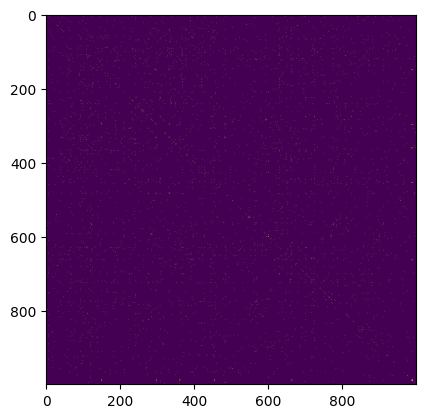

In [32]:
plt.figure()
plt.imshow(df_sorted.values[:1000, :1000])
plt.show()

In [71]:
from constants import STRING_UNIQUE_GENE_SET


geneset = set()
proteinset = set()
with open(STRING_UNIQUE_GENE_SET, 'r') as f:
    lines = f.readlines()
    for line in lines:
        geneset.add(line.strip())
        

In [72]:
len(geneset)

19699

In [ ]:
from mapping import generate_protein_gene_mapping_STRING

generate_protein_gene_mapping_STRING()

In [3]:
from constants import STRING_PROTEIN_GENE_PATH

protein_unique = set()
gene_unique = set()
with open(STRING_PROTEIN_GENE_PATH, 'r') as f:
    lines = f.readlines()
    for line in lines:
        p, g = line.strip().split()
        protein_unique.add(p)
        gene_unique.add(g)